# <font style="color:blue">Number Plate Detection</font>


##  <font style="color:green">Install pycocotools</font> 

In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

##  <font style="color:green">Install Pre-built Detectron2</font> 

In [1]:
#CUDA version
!nvidia-smi

Wed Jul 14 05:43:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla K80    On   | 00000001:00:00.0 Off |                    0 |
| N/A   37C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# for CUDA 10.1:
# !python -m pip install -U detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

# for CUDA 11.1:
!python -m pip install  -U detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.8/index.html

##  <font style="color:green">Download dataset</font> 

In [2]:
# !wget -O Dataset.zip https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1
# !unzip Dataset.zip

--2021-07-14 00:34:26--  https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1
Resolving www.dropbox.com... 162.125.9.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/k81ljpmzy3fgtx9/Dataset.zip [following]
--2021-07-14 00:34:27--  https://www.dropbox.com/s/dl/k81ljpmzy3fgtx9/Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucafa025ca4ddefc082e7d2fc381.dl.dropboxusercontent.com/cd/0/get/BSPioqQE4ytM7kZRbMhUOG5QXBxmitCSTO5fElSBJgZ-6SeDECSt_DRySZyqYJDUnnNnv9G7RplGWGOl_z_qJiSdUVyQla2fIpwH8GIp3gYQnmAlQoSbMCTuGW6B5gRNpkus0X36tcG8_Z970FY9_4gy/file?dl=1# [following]
--2021-07-14 00:34:27--  https://ucafa025ca4ddefc082e7d2fc381.dl.dropboxusercontent.com/cd/0/get/BSPioqQE4ytM7kZRbMhUOG5QXBxmitCSTO5fElSBJgZ-6SeDECSt_DRySZyqYJDUnnNnv9G7RplGWGOl_z_qJiSdUVyQla2fIpwH8GIp3gYQnmAlQoSbMCTuGW6B5gR

In [7]:
!tree -d Dataset

Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label

6 directories


In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [2]:
%matplotlib inline
%config Completer.use_jedi = False

#  <font style="color:green">Visualize Dataset</font> 




In [3]:
# write a function that loads the dataset into detectron2's standard format
def get_traffic_sign_dicts(data_root):
    dataset_dicts = []
    
    data_path = os.path.join(data_root, 'Vehicle registration plate')
    target_path = os.path.join(data_path, 'Label')
    
    for idx, filename in enumerate(os.listdir(data_path)):
        image_path = os.path.join(data_path, filename)
        if os.path.isfile(image_path):
            record = {}
            
            height, width = cv2.imread(image_path).shape[:2]
            
            record['file_name'] = image_path
            record['image_id'] = idx
            record['height'] = height
            record['width'] = width
            
            image_filename = os.path.basename(filename)
            image_name = os.path.splitext(image_filename)[0]
            annotation_path = os.path.join(target_path, '{}.txt'.format(image_name))
            annotation_rows = []
            
            with open(annotation_path, "r") as f:
                for line in f:
                    temp = line.rstrip().split(" ")
                    annotation_rows.append(temp)
                    
            objs = []
            for row in annotation_rows:

                xmin = round(float(row[3]))
                ymin = round(float(row[4]))
                xmax = round(float(row[5]))
                ymax = round(float(row[6]))

                obj= {
                    'bbox': [xmin, ymin, xmax, ymax],
                    'bbox_mode': BoxMode.XYXY_ABS,
                    # alternatively, we can use bbox_mode = BoxMode.XYWH_ABS
                    # 'bbox': [xmin, ymin, bwidth, bheight],
                    # 'bbox_mode': BoxMode.XYWH_ABS,
                    'category_id': 0,
                    'iscrowd': 0
                }

                objs.append(obj)
            record['annotations'] = objs
            dataset_dicts.append(record)

    return dataset_dicts

In [4]:
# configurations

train_root = './Dataset/train'
test_root = './Dataset/validation'

train_data_name = 'reg_plate_train'
test_data_name = 'treg_plate_test'

thing_classes = ['Reg-plate']

output_dir = 'outputs'

In [5]:
# Register train and test data
# dataset can be registered only once with one name

# register train data
DatasetCatalog.register(name=train_data_name, 
                        func=lambda: get_traffic_sign_dicts(train_root))
train_metadata = MetadataCatalog.get(train_data_name).set(thing_classes=thing_classes)

# register test data
DatasetCatalog.register(name=test_data_name, 
                        func=lambda: get_traffic_sign_dicts(test_root))
test_metadata = MetadataCatalog.get(test_data_name).set(thing_classes=thing_classes)

In [6]:
def count_files(data_root):
    i = 0
    data_path = os.path.join(data_root, 'Vehicle registration plate')
    for filename in os.listdir(data_path):
        image_path = os.path.join(data_path, filename)
        if os.path.isfile(image_path):
            i += 1
    return i

train_img_count = count_files(train_root)

In [7]:
test_data_dict = get_traffic_sign_dicts(test_root)

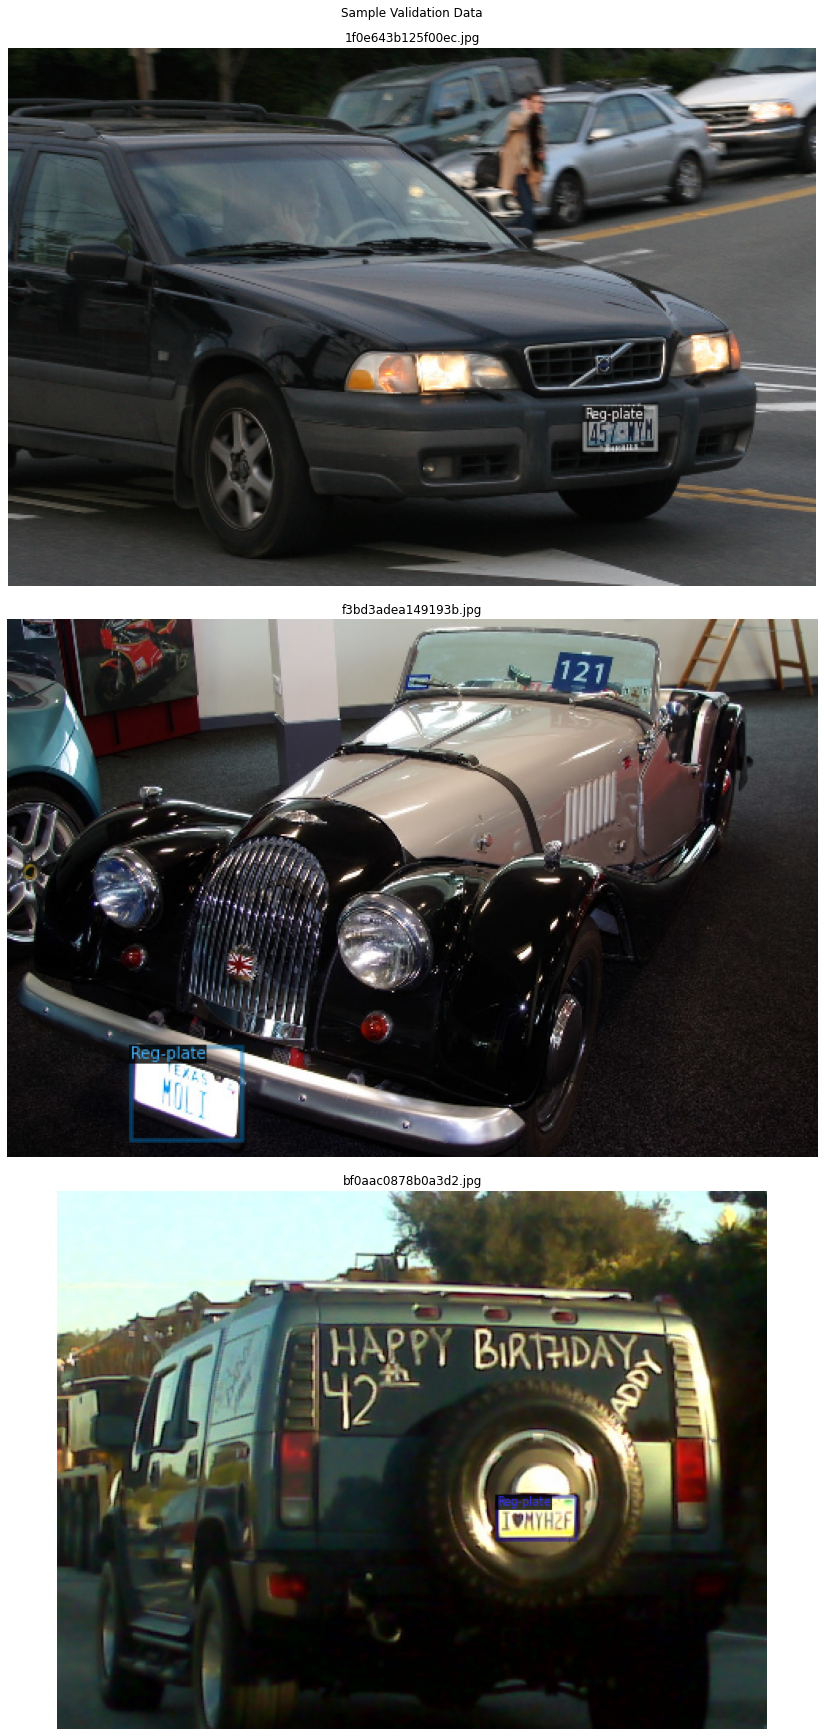

In [8]:
# lets visualize the data

fig, axs = plt.subplots(3, figsize=(12, 24), constrained_layout=True)

fig.suptitle('Sample Validation Data')

for idx, d in enumerate(random.sample(test_data_dict, 3)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=test_metadata, 
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    axs[idx].imshow(vis.get_image())
    axs[idx].axis('off')
    axs[idx].set_title(f'{os.path.basename(d["file_name"])}')

#  <font style="color:green">Training</font> 

In [9]:
# detectron2 configuration

# default configuration
cfg = get_cfg()

# update configuration with RetinaNet configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# We have registered the train and test data set with name traffic_sign_train and traffic_sign_test. 
# Let's replace the detectron2 default train dataset with our train dataset.
cfg.DATASETS.TRAIN = (train_data_name,)

# No metric implemented for the test dataset, we will have to update cfg.DATASET.TEST with empty tuple
cfg.DATASETS.TEST = ()


Loading config /anaconda/envs/azureml_py36_pytorch/lib/python3.6/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [10]:
# data loader configuration
cfg.DATALOADER.NUM_WORKERS = 4

In [11]:
# Update model URL in detectron2 config file
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

In [12]:
# solver configuration

# batch size
cfg.SOLVER.IMS_PER_BATCH = 4

# choose a good learning rate
cfg.SOLVER.BASE_LR = 0.001

# We need to specify the number of iteration for training in detectron2, not the number of epochs.
# lets convert number of epoch to number or iteration (max iteration)

epoch = 5
max_iter = int(epoch * train_img_count / cfg.SOLVER.IMS_PER_BATCH)
# max_iter = 500

cfg.SOLVER.MAX_ITER = max_iter 

In [13]:
# number of output class
# we have only one class that is Traffic Sign
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)

In [14]:
# update output directory 
cfg.OUTPUT_DIR = output_dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

###  <font style="color:purple">Set up TensorBoard</font> 


In [15]:
# %reload_ext tensorboard
# # %reload_ext tensorboard
# %tensorboard --logdir outputs --port 6006

In [16]:
# training

# trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

# if resume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

# start training
trainer.train()

[07/14 06:13:56 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.


[07/14 06:15:02 d2.engine.train_loop]: Starting training from iteration 0
[07/14 06:16:09 d2.utils.events]:  eta: 6:10:52  iter: 19  total_loss: 1.518  loss_cls: 0.9995  loss_box_reg: 0.5236  time: 3.3401  data_time: 0.0214  lr: 1.9981e-05  max_mem: 4653M
[07/14 06:17:08 d2.utils.events]:  eta: 5:50:32  iter: 39  total_loss: 1.343  loss_cls: 0.9999  loss_box_reg: 0.3685  time: 3.1350  data_time: 0.0102  lr: 3.9961e-05  max_mem: 4653M
[07/14 06:18:04 d2.utils.events]:  eta: 5:28:47  iter: 59  total_loss: 1.54  loss_cls: 0.9621  loss_box_reg: 0.4582  time: 3.0105  data_time: 0.0092  lr: 5.9941e-05  max_mem: 4653M
[07/14 06:19:01 d2.utils.events]:  eta: 5:26:35  iter: 79  total_loss: 0.9972  loss_cls: 0.6778  loss_box_reg: 0.3266  time: 2.9769  data_time: 0.0090  lr: 7.9921e-05  max_mem: 4653M
[07/14 06:19:58 d2.utils.events]:  eta: 5:19:21  iter: 99  total_loss: 0.9714  loss_cls: 0.6368  loss_box_reg: 0.3151  time: 2.9424  data_time: 0.0111  lr: 9.9901e-05  max_mem: 4653M
[07/14 06:20:56

#  <font style="color:green">Inference</font> 

In [18]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


# update RetinaNet score threshold 
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

cfg.DATASETS.TEST = (test_data_name,)

# predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)


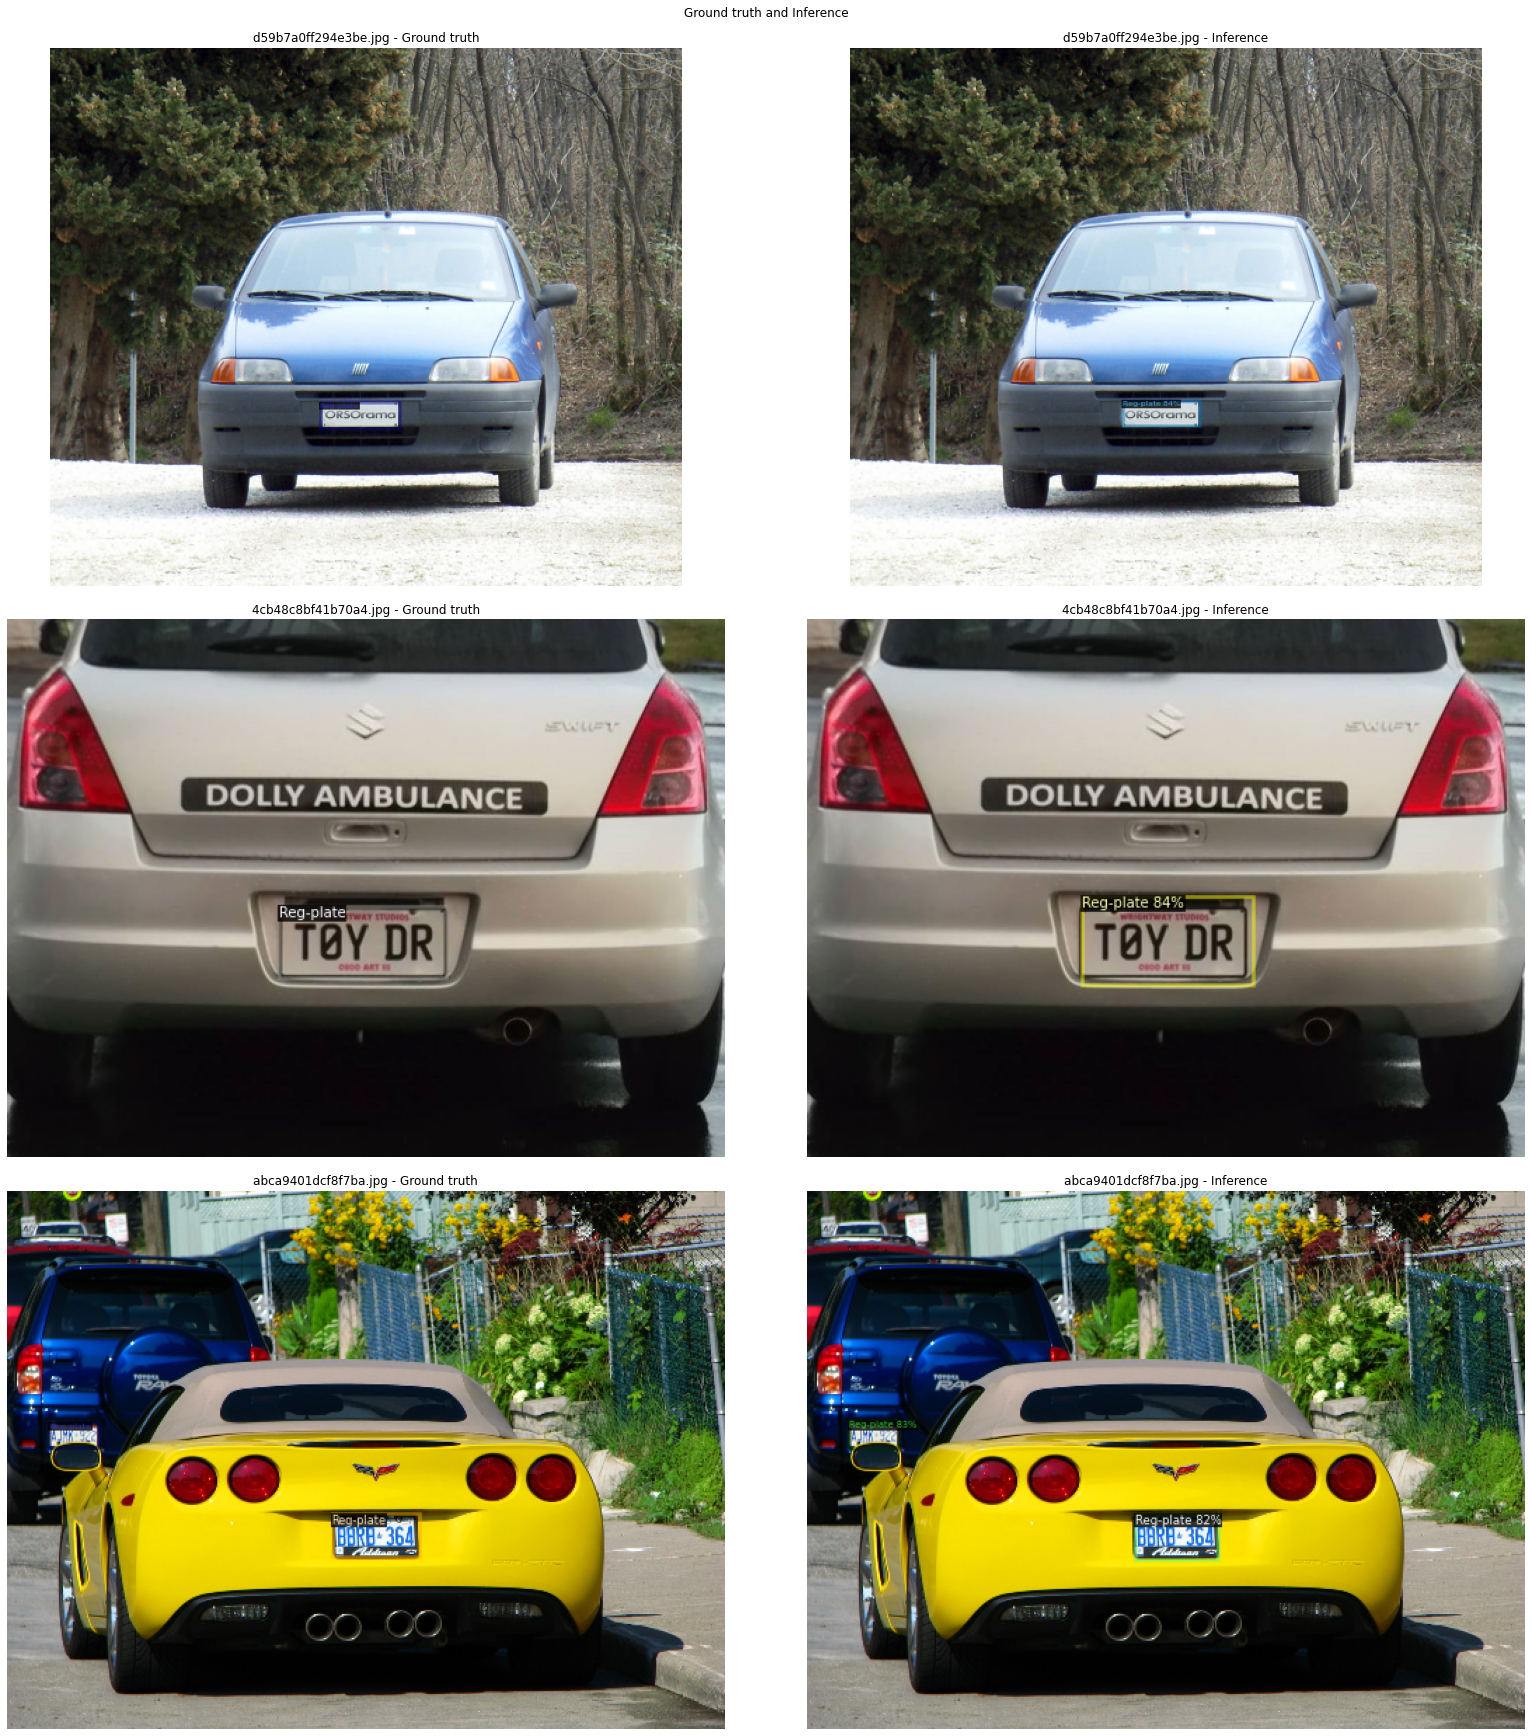

In [33]:
# let's have a look on prediction
fig, axs = plt.subplots(3, 2, figsize=(22, 24), constrained_layout=True)

fig.suptitle('Ground truth and Inference')

r_sample = random.sample(test_data_dict, 3)

for idx, d in enumerate(r_sample):
    
    img = cv2.imread(d["file_name"])
    
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    
    axs[idx, 0].imshow(vis.get_image())
    axs[idx, 0].axis('off')
    axs[idx, 0].set_title(f'{os.path.basename(d["file_name"])} - Ground truth')
    
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=test_metadata, scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    axs[idx, 1].imshow(v.get_image())
    axs[idx, 1].axis('off')
    axs[idx, 1].set_title(f'{os.path.basename(d["file_name"])} - Inference')



#  <font style="color:green">COCO Detection Evaluation</font> 

In [34]:
# directory for evaluation
eval_dir = os.path.join(cfg.OUTPUT_DIR, 'coco_eval')
os.makedirs(eval_dir, exist_ok=True)

# evaluator instance with coco evaluator
evaluator = COCOEvaluator(dataset_name=test_data_name, 
                          tasks=cfg, 
                          distributed=False, 
                          output_dir=eval_dir)

# validation data loader
val_loader = build_detection_test_loader(cfg, test_data_name)

# start validation
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/14 11:58:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/14 11:58:02 d2.evaluation.coco_evaluation]: 'treg_plate_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/14 11:58:02 d2.data.datasets.coco]: Converting annotations of dataset 'treg_plate_test' to COCO format ...)
[07/14 11:58:07 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/14 11:58:07 d2.data.datasets.coco]: Conversion finished, #images: 386, #annotations: 512
[07/14 11:58:07 d2.data.datasets.coco]: Caching COCO format annotations at 'outputs/coco_eval/treg_plate_test_coco_format.json' ...
[07/14 11:58:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| Reg-plate  | 512          |
|            |              |
[07/14 11:58:12 d2.data.dataset_mapper]: [Dat

OrderedDict([('bbox',
              {'AP': 60.97615712837563,
               'AP50': 90.22837442841869,
               'AP75': 71.7644145896058,
               'APs': 29.731265236668186,
               'APm': 70.26345772966472,
               'APl': 69.84926171036936})])

# <font style="color:green">Inference on a Video</font>

In [48]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc(*"MPEG"),
        fps=float(frames_per_second),
        frameSize=(width, height),
        isColor=True,
    )
    
        
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            outputs = predictor(frame)
            v = Visualizer(frame[:, :, ::-1],
                           metadata=test_metadata)
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            output_file.write(v.get_image())
#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
            i += 1
        else:
            break
        
    video.release()
    output_file.release()
    
    return

In [49]:
video_read_write("sample-video.mp4")

# <font style="color:green">Tensorboard logs</font>
#### You can view tensorboard logs from [here](https://tensorboard.dev/experiment/3xyAghxfRtycPFqDemeHLA/).


In [58]:
!tensorboard dev upload --logdir 'outputs' --name "Object Detection" --description "Number plate detection"

2021-07-14 12:55:04.828261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/3xyAghxfRtycPFqDemeHLA/

[2021-07-14T12:55:06] Started scanning logdir.
[2021-07-14T12:55:07] Total uploaded: 2840 scalars, 0 tensors, 0 binary objects
^C2KListening for new data in logdir...


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/3xyAghxfRtycPFqDemeHLA/
